In [1]:
import ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [2]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    deposit: float
    time: str
    type: str
    is_win: bool

def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float, INITIAL_MARGIN: float) -> float:
    
    val = cash 

    # Longs
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Shorts
    short_val = sum(
        pos.price * pos.n_shares * INITIAL_MARGIN + (pos.price - current_price) * pos.n_shares * (1 - COM) + pos.deposit
        for pos in short_ops
    )

    return val + short_val

In [3]:
def split_data(data: pd.DataFrame):
    """
    Split the data into training, testing, and validation sets.

    Parameters:
        data (pd.DataFrame): Cleaned market data.

    Returns:
        tuple: (train, test, validation) DataFrames.
    """
    
    # 60% train, 20% test, 20% validation
    train_size = int(len(data) * 0.6)
    test_size = int(len(data) * 0.2)

    # Split
    train = data[:train_size]
    test = data[train_size:train_size + test_size]
    validation = data[train_size + test_size:]

    return train, test, validation

def trade_signals(data):
    data = data.copy()
    rt = data.Close.pct_change()
    data['buy_signal'] = rt > 0.005
    data['sell_signal'] = rt < -0.005
    return data

def ks_drift(reference_data: pd.Series, new_data: pd.Series, alpha: float = 0.05) -> float:
    """
    Calculate the Kolmogorov-Smirnov statistic to detect data drift between two datasets.

    Parameters:
        reference_data (pd.Series): Reference dataset.
        new_data (pd.Series): New dataset to compare against the reference.

    Returns:
        float: KS statistic indicating the degree of drift.
    """
    statistic, p_value = ks_2samp(reference_data, new_data)
    return p_value < alpha


def calculate_drift_metrics(reference_df: pd.DataFrame, new_df: pd.DataFrame, alpha: float = 0.05) -> dict:
    """
    Calculate drift metrics for each feature in the datasets.

    Returns a dict: {feature_name: True/False} indicating drift.
    """
    drift_results = {}
    for column in reference_df.columns:
        drift_detected = ks_drift(reference_df[column], new_df[column], alpha)
        drift_results[column] = drift_detected

    return drift_results

def calculate_drift_pvalues(reference_df: pd.DataFrame, new_df: pd.DataFrame) -> dict:
    """
    Calculate p-values for each feature in the datasets.

    Returns a dict: {feature_name: p_value}.
    """
    p_values = {}
    for column in reference_df.columns:
        _, p_value = ks_2samp(reference_df[column], new_df[column])
        p_values[column] = p_value

    return p_values

In [4]:
data = pd.read_csv('aapl_5m_train.csv').dropna()
data.drop(columns=['Unnamed: 0','Timestamp','Gmtoffset','Open','High','Low','Volume'], inplace=True)
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)

In [5]:
rsi_1 = ta.momentum.RSIIndicator(data.Close, window=15)
data['rsi_1'] = rsi_1.rsi()

rsi_2 = ta.momentum.RSIIndicator(data.Close, window=30)
data['rsi_2'] = rsi_2.rsi()

data = data.dropna()

train, test, validation = split_data(data)

In [6]:
train = trade_signals(train)
test = trade_signals(test)
validation = trade_signals(validation)

In [7]:
# Saving normalization parameters
mean_rsi_1_train = train['rsi_1'].mean()
std_rsi_1_train = train['rsi_1'].std()
mean_rsi_2_train = train['rsi_2'].mean()
std_rsi_2_train = train['rsi_2'].std()

In [8]:
# Normalizing RSI features
train['rsi_1'] = (train['rsi_1'] - mean_rsi_1_train) / std_rsi_1_train
train['rsi_2'] = (train['rsi_2'] - mean_rsi_2_train) / std_rsi_2_train

test['rsi_1'] = (test['rsi_1'] - mean_rsi_1_train) / std_rsi_1_train
test['rsi_2'] = (test['rsi_2'] - mean_rsi_2_train) / std_rsi_2_train

validation['rsi_1'] = (validation['rsi_1'] - mean_rsi_1_train) / std_rsi_1_train
validation['rsi_2'] = (validation['rsi_2'] - mean_rsi_2_train) / std_rsi_2_train

## <font color='cornflowerblue'> Parameters

In [9]:
COM: float = 0.125 / 100
BORROW_RATE: float = 0.25 / 100
INITIAL_MARGIN = 1.5
MAINTENANCE_MARGIN = 1.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = BORROW_RATE / bars_per_year

# DOF
STOP_LOSS: float = 0.1
TAKE_PROFIT: float = 0.1
N_SHARES: int = 50

## <font color='cornflowerblue'> Backtest

In [10]:
initial_capital: float = 1_000_000
capital = initial_capital

winning_trades: int = 0
long_trades: int = 0
short_trades: int = 0

portfolio_value = []
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []
all_positions: list[Position] = []

# ----- IMPORTANT ----- #
# Get only the features for drift calculation
train_base = train.iloc[:,1:3]
test_compare = test.iloc[:,1:3]

# To make the rolling windows for testing drift
WINDOW_TOTAL = 90
STEP = 30

# List to store drift results
data_drift_results: list[dict] = []
p_values_list: list[dict] = []
# ------------------------- #

for i, row in enumerate(test.itertuples(index=False)):

    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            pnl = (row.Close - position.price) * position.n_shares * (1 - COM)
            capital += row.Close * position.n_shares * (1 - COM)

            if pnl > 0:
                winning_trades += 1
                position.is_win = True
            # Remove position from active position
            active_long_positions.remove(position)

    equity: float = 0.0
    required_equity: float = 0.0

    # -- SHORT -- #
    for position in active_short_positions.copy():
        # Apply borrow rate to active short positions
        cover_cost = row.Close * position.n_shares
        initial_account = position.price * position.n_shares * INITIAL_MARGIN
        borrow_cost = cover_cost * bar_borrow_rate
        capital -= borrow_cost

        # Calculate equity and required equity
        equity += initial_account + position.deposit
        required_equity += MAINTENANCE_MARGIN * cover_cost

    for position in active_short_positions.copy():
        # Check Margin call
        if equity < required_equity:
            # Margin Call
            deposit = (required_equity * 1.2) - equity

            if capital > deposit:
                # Make deposit to margin account
                print(f'Margin Call at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit: {deposit:.2f}')
                capital -= deposit
                equity += deposit
                position.deposit += deposit

            else:
                # We have to close the position
                print(f'Forced Close at {row.Datetime} | Equity: {equity:.2f} | Required Equity: {required_equity:.2f} | Deposit Needed: {deposit:.2f} | Capital: {capital:.2f} \n')
                pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
                capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

                if pnl > 0:
                    winning_trades += 1
                    position.is_win = True

                active_short_positions.remove(position)
                continue

        if row.Close < position.tp or row.Close > position.sl:
            # Add profits / losses to capital
            pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
            capital += pnl + position.price * position.n_shares * INITIAL_MARGIN + position.deposit

            if pnl > 0:
                winning_trades += 1
                position.is_win = True

            active_short_positions.remove(position)
            continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           deposit=0, time=row.index, type='long', is_win=False)
            active_long_positions.append(pos)
            all_positions.append(pos)
            long_trades += 1

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        margin_requirement = row.Close * N_SHARES * INITIAL_MARGIN
        commission = row.Close * N_SHARES * COM
        cost = margin_requirement + commission

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                           deposit=0, time=row.index, type='short', is_win=False)
            active_short_positions.append(pos)
            all_positions.append(pos)
            short_trades += 1

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM, INITIAL_MARGIN))

    # ----- IMPORTANT, LOGIC FOR DATA DRIFT DETECTION ----- #
    # i is 0-based from enumerate
    k = i + 1  # number of rows seen so far in 'test'
    if k >= WINDOW_TOTAL and ((k - WINDOW_TOTAL) % STEP == 0):
        #WINDOW_TOTAL = 90
        # STEP = 30
        start = k - WINDOW_TOTAL
        end = k

        # Make the df with the window size you established
        new_df = test_compare.iloc[start:end]

        # Detecting drift
        drift_result = calculate_drift_metrics(train_base, new_df, alpha=0.05)
        data_drift_results.append(drift_result)
        
        # Calculate p-values
        p_values = calculate_drift_pvalues(train_base, new_df)
        p_values_list.append(p_values)
    # ----------------------------------------------------- #

# At the end of the backtesting, we should close all active positions

# Closing long positions
for position in active_long_positions:
    pnl = (row.Close - position.price) * position.n_shares * (1 - COM)
    capital += row.Close * position.n_shares * (1 - COM)

    if pnl > 0:
        winning_trades += 1
        position.is_win = True

for position in active_short_positions:
    pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
    capital += pnl + position.price * N_SHARES * INITIAL_MARGIN + position.deposit

    if pnl > 0:
        winning_trades += 1
        position.is_win = True

In [11]:
data_drift_df = pd.DataFrame(data_drift_results)
data_drift_df

,rsi_1,rsi_2
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
253,True,True
254,False,True
255,False,True
256,False,False


In [12]:
p_values_df = pd.DataFrame(p_values_list)
p_values_df

,rsi_1,rsi_2
0,1.122526e-10,7.801737e-17
1,1.551898e-02,1.401021e-09
2,7.512949e-05,2.908143e-11
3,3.786671e-12,1.676707e-21
4,1.207280e-21,2.588602e-31
...,...,...
253,4.074380e-04,5.306451e-07
254,1.440683e-01,1.232156e-05
255,4.239234e-01,2.013304e-04
256,2.441935e-01,6.483845e-02


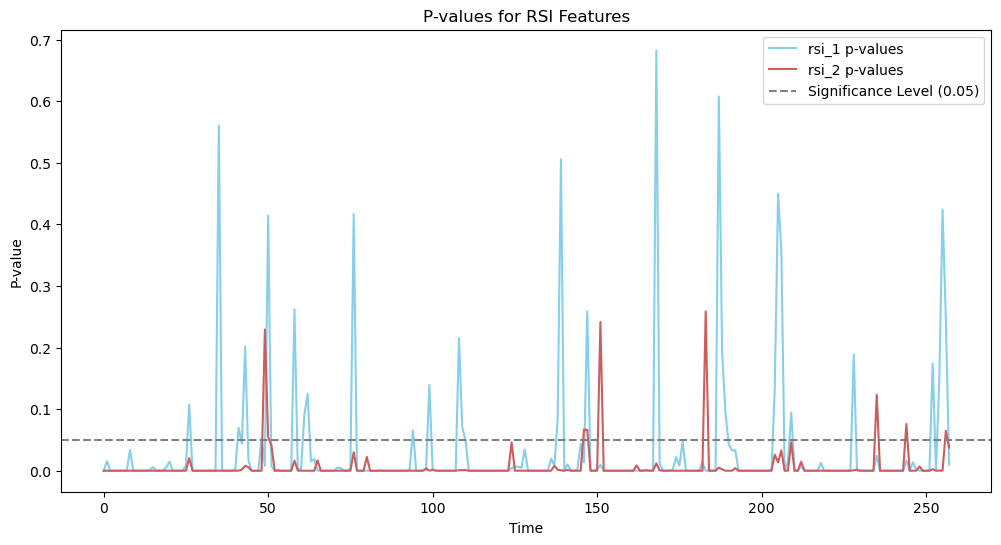

In [13]:
plt.figure(figsize=(12,6))
plt.plot(p_values_df['rsi_1'], color='skyblue', label='rsi_1 p-values')
plt.plot(p_values_df['rsi_2'], color='indianred', label='rsi_2 p-values')
plt.title('P-values for RSI Features')
plt.xlabel('Time')
plt.ylabel('P-value')
plt.axhline(y=0.05, color='gray', linestyle='--', label='Significance Level (0.05)')
plt.legend()
plt.show()

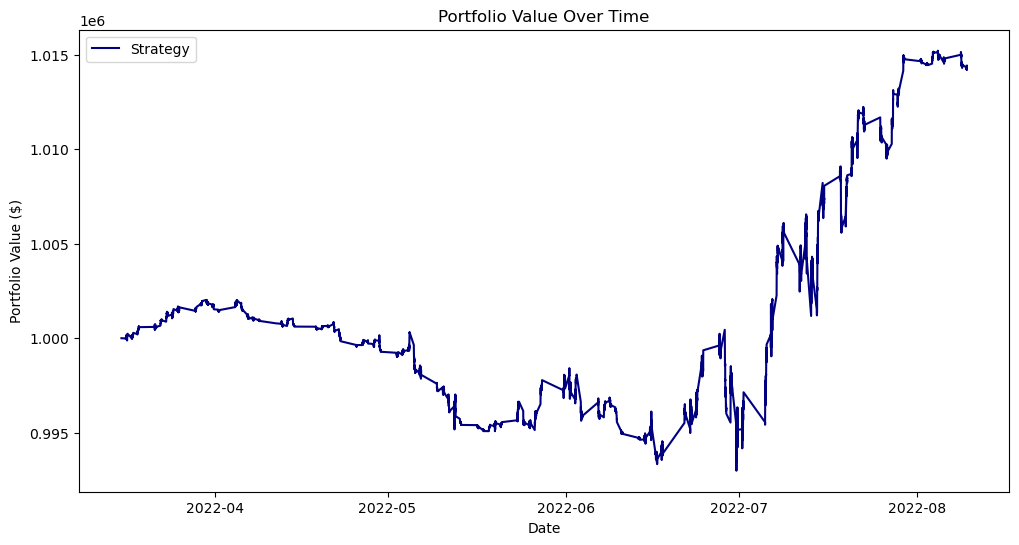

In [14]:
df = pd.DataFrame({'Portfolio Value': portfolio_value},
                  index=test.index)

rt = test.Close.pct_change()
buy_and_hold = (1 + rt).cumprod() * initial_capital

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Portfolio Value'], label='Strategy', color='navy')
#plt.plot(df.index, buy_and_hold, label='Buy and Hold', color='indianred', alpha=0.5)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()